### Introduction

### Approach

### Simulation Notes

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [65]:
from typing import Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import datetime
import matplotlib.dates as mdates
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable


from datetime import timedelta, date, datetime
import time
import os
import pickle

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

from jax import random
import numpyro
import numpyro.distributions as dist

import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u
import scenario_generator.curated as curated

import mechafil.minting as minting
import mechafil.data as mecha_data
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, setup_spacescope
from mechafil.power import forecast_power_stats, build_full_power_stats_df, scalar_or_vector_to_vector
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df
from mechafil.supply import forecast_circulating_supply_df

from cel_utils import disk_utils

In [3]:
# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

today = datetime.today().date()
DATA_LAG_DAYS = 2
current_date = today - timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - date(2020, 10, 15)).days

start_date = date(2023, 6, 1)  # seed network w/ data uptil this date
start_day = (start_date - date(2020, 10, 15)).days

# Forecast
forecast_lenght = 365 * 5
end_day = current_day + forecast_lenght
end_date = current_date + timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)
duration = 365 # sector duration

# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

auth_config='/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'
setup_spacescope(auth_config)

class ArrayWrapperObj:
    def __init__(self, arr):
        self.arr = arr
    def get(self):
        return self.arr

2023-06-01
2023-06-28
2028-06-26


In [46]:
def preprocess_expirations():
    # expirations
    res = get_sector_expiration_stats(start_date, current_date,end_date)

    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]

    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)

    current_day_stats = fil_stats_df[fil_stats_df["date"] >= current_date].iloc[0]

    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0
    
    return rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df

def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
            df_out[c] = df_out[c].clip(lower=1e-6)
    return df_out

def run_sim(fil_plus_rate:Union[float, np.array], 
            rb_onboard_power:[float, np.array], 
            renewal_rate:[float, np.array])->pd.DataFrame():
    setup_spacescope(auth_config)
    future_renewal_rate = scalar_or_vector_to_vector(renewal_rate, forecast_lenght)
    renewal_rate_vec = np.concatenate([historical_renewal_rate[:-1],future_renewal_rate])
    
    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        future_renewal_rate,
        fil_plus_rate,
        duration,
        forecast_lenght,
        qap_method='basic'
    )
    
    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0

    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )

    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values
    
    # minting 
    mint_df = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        baseline_power_array = baseline_power_array,
        zero_cum_capped_power = zero_cum_capped_power
    )
    
    return rb_power_df, qa_power_df, power_df, mint_df

In [47]:
offline_info_dir = 'offline'
output_dir = 'output'
os.makedirs(offline_info_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [48]:
# separate expensive preprocessing from MCMC loop
@disk_utils.cache_data(directory=offline_info_dir)
def get_historical_data():
    rb_known_scheduled_expire_vec, qa_known_scheduled_expire_vec, known_scheduled_pledge_release_full_vec, rb_power_zero, qa_power_zero, fil_stats_df = preprocess_expirations()
    _, historical_renewal_rate = u.get_historical_renewal_rate(start_date-timedelta(days=1), current_date)
    baseline_power_array = minting.compute_baseline_power_array(start_date, end_date)
    zero_cum_capped_power = mecha_data.get_cum_capped_rb_power(start_date)
    
    return {
        'rb_known_scheduled_expire_vec':rb_known_scheduled_expire_vec,
        'qa_known_scheduled_expire_vec':qa_known_scheduled_expire_vec,
        'known_scheduled_pledge_release_full_vec':known_scheduled_pledge_release_full_vec,
        'rb_power_zero':rb_power_zero,
        'qa_power_zero':qa_power_zero,
        'fil_stats_df':fil_stats_df,
        'historical_renewal_rate': historical_renewal_rate,
        'baseline_power_array': baseline_power_array,
        'zero_cum_capped_power': zero_cum_capped_power
    }
    
hist_data = get_historical_data()
locals().update(hist_data)

In [50]:
delta = 0.05
pct_max_vec = np.arange(0.1, 1.0, delta)
target_max_vec = [180]

results = {}
for pct_max in tqdm(pct_max_vec):
    for target in target_max_vec:
        sp = curated.forecast_smooth_scenario(forecast_lenght,
                                              pct_max,
                                              target,
                                              rb_onboard_setting = 'smooth_pcttarget',
                                              renewal_rate_setting = 'smooth_pcttarget',
                                              filplus_rate_setting = 'smooth_pcttarget')
        # note htat FIL+ rate is a noop
        rb_power_df, qa_power_df, power_df, mint_df = run_sim(sp['rb_onboard_power'], sp['renewal_rate'], sp['filplus_rate'])
        res_dict = {
            'mint_df': mint_df,
            'rb_onboard_power': sp['rb_onboard_power'],
            'renewal_rate': sp['renewal_rate'],
        }
        k = '%0.02f,%d' % (pct_max, target)
        results[k] = res_dict

  0%|          | 0/18 [00:00<?, ?it/s]

In [52]:
def plt_x(ax, results_dict, res_key='mint_df',
          quantity_to_plot='network_RBP', 
          scale_by=1
         ):  
    colors=cm.get_cmap("PRGn")
    for pct_max in pct_max_vec:
        cc = colors(pct_max)
        res = results[('%0.02f,%d') % (pct_max,target_max_vec[0])][res_key]
        ax.plot(res['date'], res[quantity_to_plot]/scale_by, color=cc)

In [98]:
# get histoircal data for plotting purposes
t_vec, historical_rbonboard_pw = u.get_historical_daily_onboarded_power(date(2021,3,15), current_date)
t_rr, historical_renewal_rate = u.get_historical_renewal_rate(date(2021,3,15), current_date)

<IPython.core.display.Javascript object>


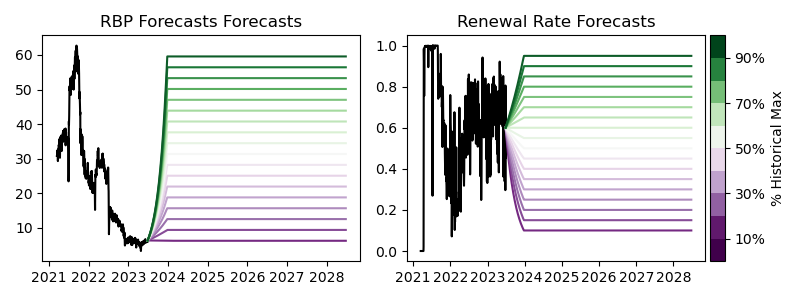

In [99]:
# plot the inputs
fig, axs = plt.subplots(1,2, sharex=True, figsize=(8,3))

# TODO: plot historical also

colors=cm.get_cmap("PRGn")
axs[0].plot(t_vec, historical_rbonboard_pw, color='k')
t_forecast = [datetime.date(t_vec.iloc[-1])+timedelta(days=i) for i in range(forecast_lenght)]
for pct_max in pct_max_vec:
    cc = colors(pct_max)
    res = results[('%0.02f,%d') % (pct_max,target_max_vec[0])]['rb_onboard_power']
    axs[0].plot(t_forecast, res, color=cc)
axs[0].set_title('RBP Forecasts Forecasts')

axs[1].plot(t_rr, historical_renewal_rate, color='k')
t_forecast = [datetime.date(t_rr.iloc[-1])+timedelta(days=i) for i in range(forecast_lenght)]
for pct_max in pct_max_vec:
    cc = colors(pct_max)
    res = results[('%0.02f,%d') % (pct_max,target_max_vec[0])]['renewal_rate']
    axs[1].plot(t_forecast, res, color=cc)
axs[1].set_title('Renewal Rate Forecasts')

divider = make_axes_locatable(axs[1])
cbar_ax = divider.append_axes('right', size='5%', pad=0.05)
vmin = min(pct_max_vec)
vmax = max(pct_max_vec)
norm = mpl.colors.Normalize(vmin=vmin,vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=colors, norm=norm)
sm.set_array([])
delta = 0.1
cbar = fig.colorbar(sm, ticks=[0.1, 0.3, 0.5, 0.7, 0.9], 
                    boundaries=np.arange(vmin-delta,vmax+delta,delta),
                    cax=cbar_ax,
                    label='% Historical Max')
cbar.ax.set_yticklabels(['10%', '30%', '50%', '70%', '90%']) 

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'counterfactual_inputs.png'))

In [72]:
def find_minting_crossings(df):
    dff = df.copy()
    dff['day_simple_reward'] = df['cum_simple_reward'].diff().fillna(method='backfill')
    
    df_crossing = dff[(dff.day_network_reward)*0.98 <= dff.day_simple_reward]
    if len(df_crossing) > 0:
        xing_i = df_crossing.iloc[0]['date']
        return xing_i
    return None

<IPython.core.display.Javascript object>


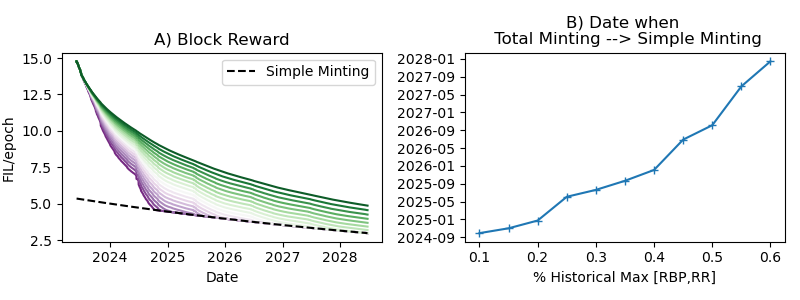

In [102]:
fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(8,3))

# plot hypothetical minting rates
plt_x(axs[0], results, quantity_to_plot='day_network_reward', scale_by=(5*2880))
r0 = results[list(results.keys())[0]]['mint_df']
day_simple_reward = r0['cum_simple_reward'].diff().fillna(method='backfill')
axs[0].plot(r0['date'], day_simple_reward/(5*2880), color='k', linestyle='--', label='Simple Minting')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('FIL/epoch')
axs[0].set_title('A) Block Reward')
axs[0].legend()

# plot minting crossing dates as a function of RBP+RR % of max
crossing_dates = []
for k in results.keys():
    mdf = results[k]['mint_df']
    crossing_dates.append(find_minting_crossings(mdf))
axs[1].plot(pct_max_vec, crossing_dates, marker='+')
axs[1].set_xlabel('% Historical Max [RBP,RR]')
axs[1].set_title('B) Date when \n Total Minting --> Simple Minting')

plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'counterfactual_outputs.png'))